In [2]:
import pandas as pd, networkx as nx, numpy as np, matplotlib.pyplot as plt
import matplotlib.patheffects as patheffects
import random,time,itertools,tqdm,collections
from sklearn.feature_extraction.text import TfidfVectorizer
from networkx.drawing.nx_agraph import graphviz_layout
import re

In [3]:
def get_journal_name_original(citing):
    '''
    citnig(列)：['primary_location']列しか取れない

    '''
    try:
        return citing['source']['display_name']
    except:
        return None

def get_topic(topic_raw,class_):
    '''
    topic()：['primary_location']列しか取れない
    class(str):domain,field,subfieldから選ぶ
    '''
    if class_ == "domain":
        try:
          return topic_raw['domain']["display_name"]

        except:
          return None

    elif class_ == "field":
        try:
          return topic_raw['field']["display_name"]

        except:
          return None

    elif class_ == "subfield":

        try:
         return topic_raw['subfield']["display_name"]

        except:
          return None



def remove_parentheses(text):
    """
    文字列から()で囲まれた部分を含む文字列を削除し、
    ()の前に半角スペースがある場合、そのスペースも削除する関数

    Parameters:
        text (str): 対象の文字列

    Returns:
        str: ()で囲まれた部分が削除された文字列
    """
    return re.sub(r'\s*\([^()]*\)', '', text)


#プロット用の色の辞書
journal_colors = {
    'Scientometrics': '#000080',  # ネイビー
    'SSS': '#ff7f0e',  # オレンジ
    'RePoli': '#2ca02c',  # 緑
    'STHV': '#d62728',  # 赤
    'Technovation': '#9467bd',  # 紫
    'PUS': '#8c564b',  # 茶
    'Minerva': '#e377c2',  # ピンク
    'SciCom': '#7f7f7f',  # グレー
    'SasC': '#bcbd22',  # 黄緑
    'ReEval': '#17becf',  # 水色
    'STS': '#ff9896',  # ピンク
    'JRI': '#1f77b4',  # 青
    'EASTS': '#ffbb78',  # ピーチ
    'TIS': 'teal',  #ディール
    'SPP': 'olive',  # おりーぶ
    'JCOM': 'darkolivegreen'  # ダークグリーン
}


In [5]:
##元データの生成方法

# path = "all_STS0508.json"
# df = pd.read_json(path, orient="records")
# #参考文献の数
# for i in range(df.shape[0]):
#     referenced_works = df.loc[i, "referenced_works"]
#     referenced_count = len(referenced_works)
#     df.loc[i, "referenced_count"] = referenced_count
# #フィールド
# df['field'] = df["primary_topic"].apply(get_topic, class_="field" )
# #サブフィールド
# df['subfield'] = df["primary_topic"].apply(get_topic, class_="subfield" )
# df.drop(['primary_topic', 'primary_location','referenced_works'], axis=1, inplace=True)

# データの読み込み

In [8]:
df = pd.read_json("basic_inf.json",orient="records")
#2024は邪魔
df = df[df['publication_year'] != 2024]

In [141]:
#大まかな分布
from collections import Counter
Counter(df['journal_name'])

Counter({'Scientometrics': 7601,
         'SSS': 2107,
         'RePoli': 4720,
         'STHV': 2006,
         'Technovation': 3432,
         'TIS': 2853,
         'PUS': 1758,
         'SPP': 4240,
         'Minerva': 2272,
         'SciCom': 1000,
         'SasC': 1279,
         'ReEval': 1056,
         'STS': 727,
         'JRI': 369,
         'EASTS': 1002,
         'JCOM': 1190})

# ジャーナルごとの出版数

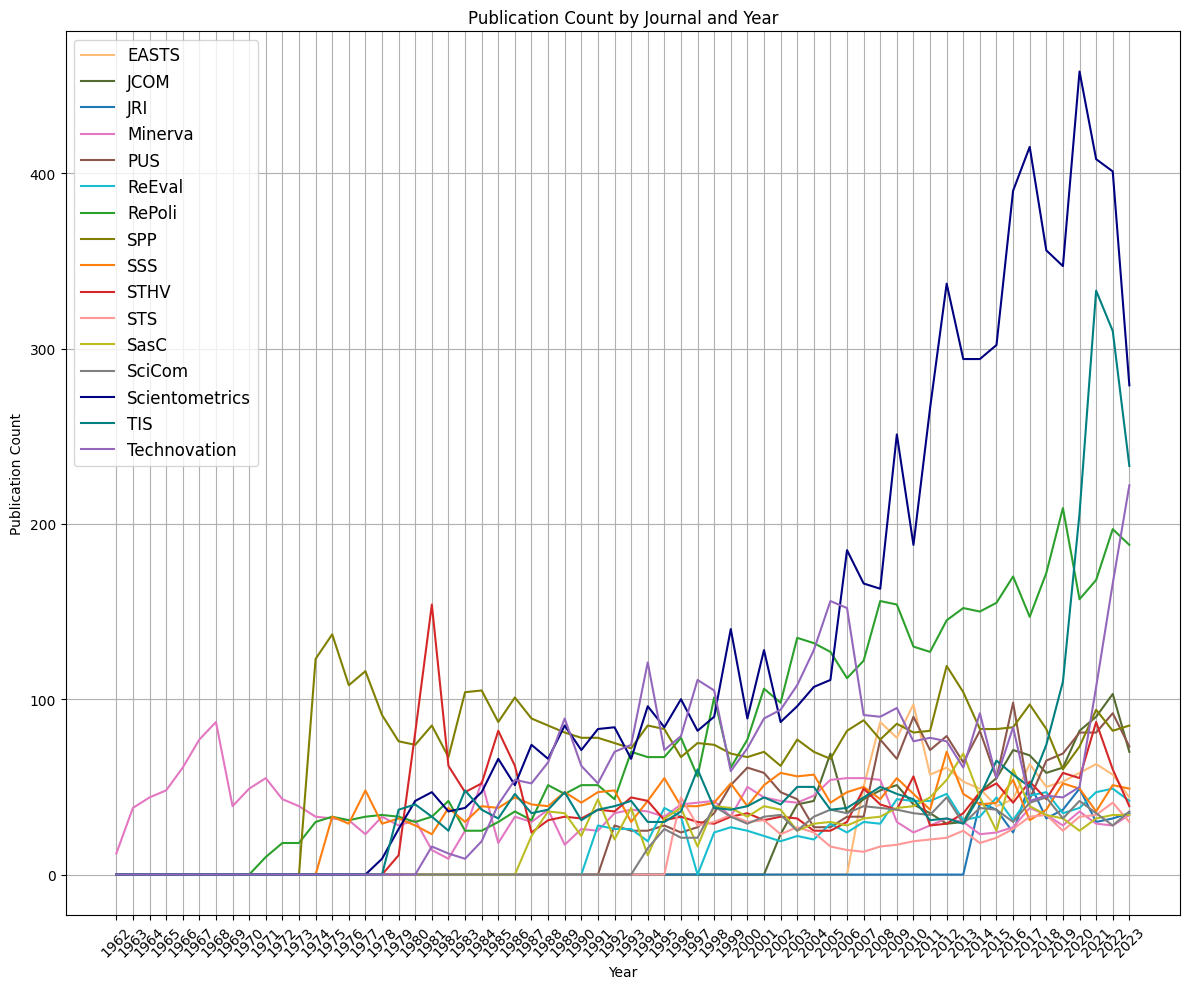

In [143]:
# ジャーナルでグループ化して年ごとの出版数を計算
journal_year_counts = df.groupby(['journal_name', 'publication_year']).size().unstack(fill_value=0)



# グラフのサイズを設定
plt.figure(figsize=(12, 10))  # 図のサイズを調整

# ジャーナルごとにループしてプロット
for journal in journal_year_counts.index:
    plt.plot(journal_year_counts.columns, journal_year_counts.loc[journal], label=journal, color=journal_colors.get(journal, 'k'))

# グラフのタイトルとラベルを設定
plt.title('Publication Count by Journal and Year')
plt.xlabel('Year')
plt.ylabel('Publication Count')

# 凡例の設定
plt.legend(loc='upper left', fontsize='large')  # 凡例を内側の左上に配置、フォントサイズをlargeに設定

# x軸を整数値に設定
plt.xticks(journal_year_counts.columns, rotation=45)

# グリッドを表示
plt.grid(True)

# グラフを表示
plt.tight_layout()
plt.show()


# 年ごとのトピックの種類の変化


*   フィールド/サブフィールドの変化
*   出版数と概ね相関しているので、徐々にトピックが減ったということはなさそう



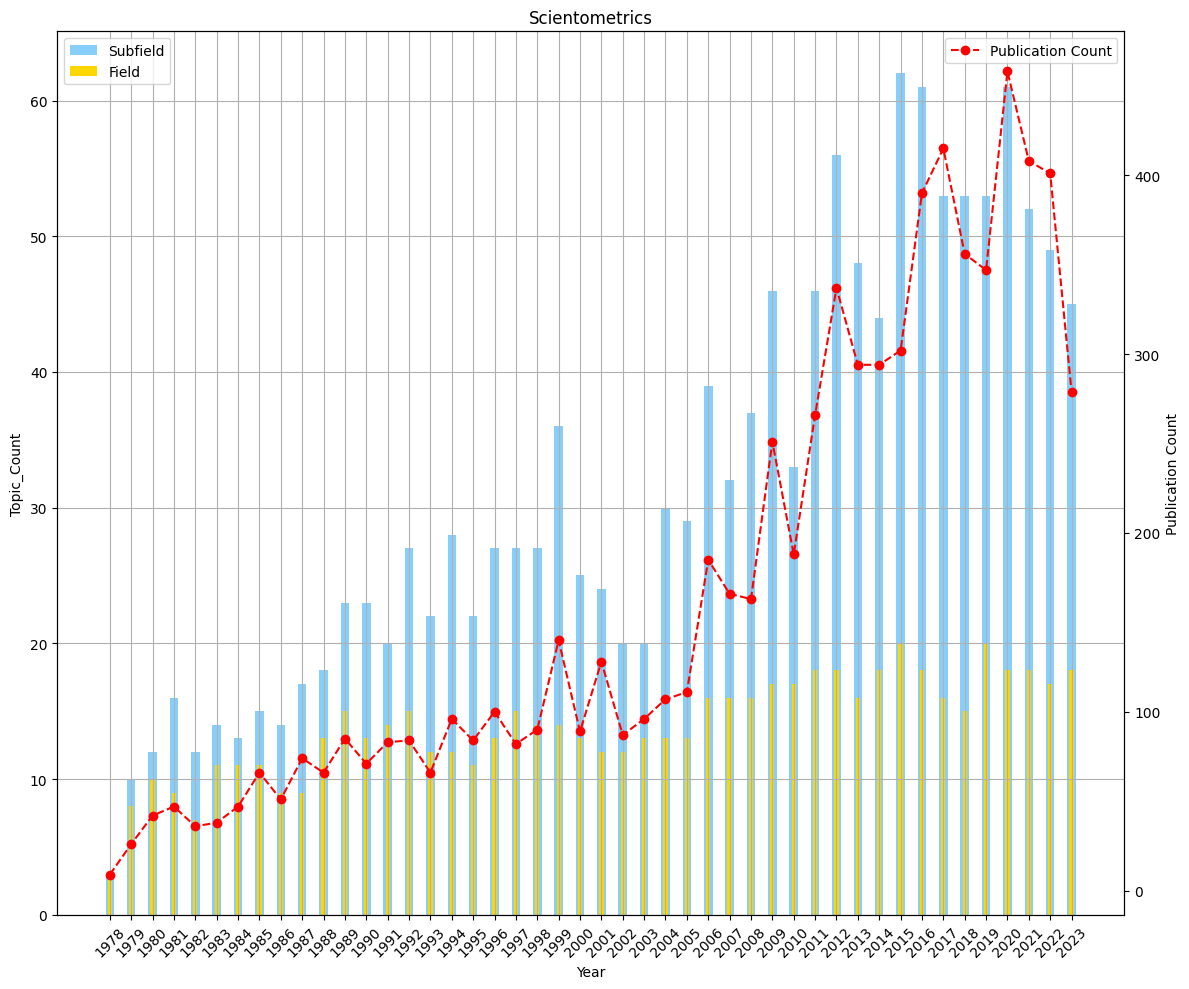

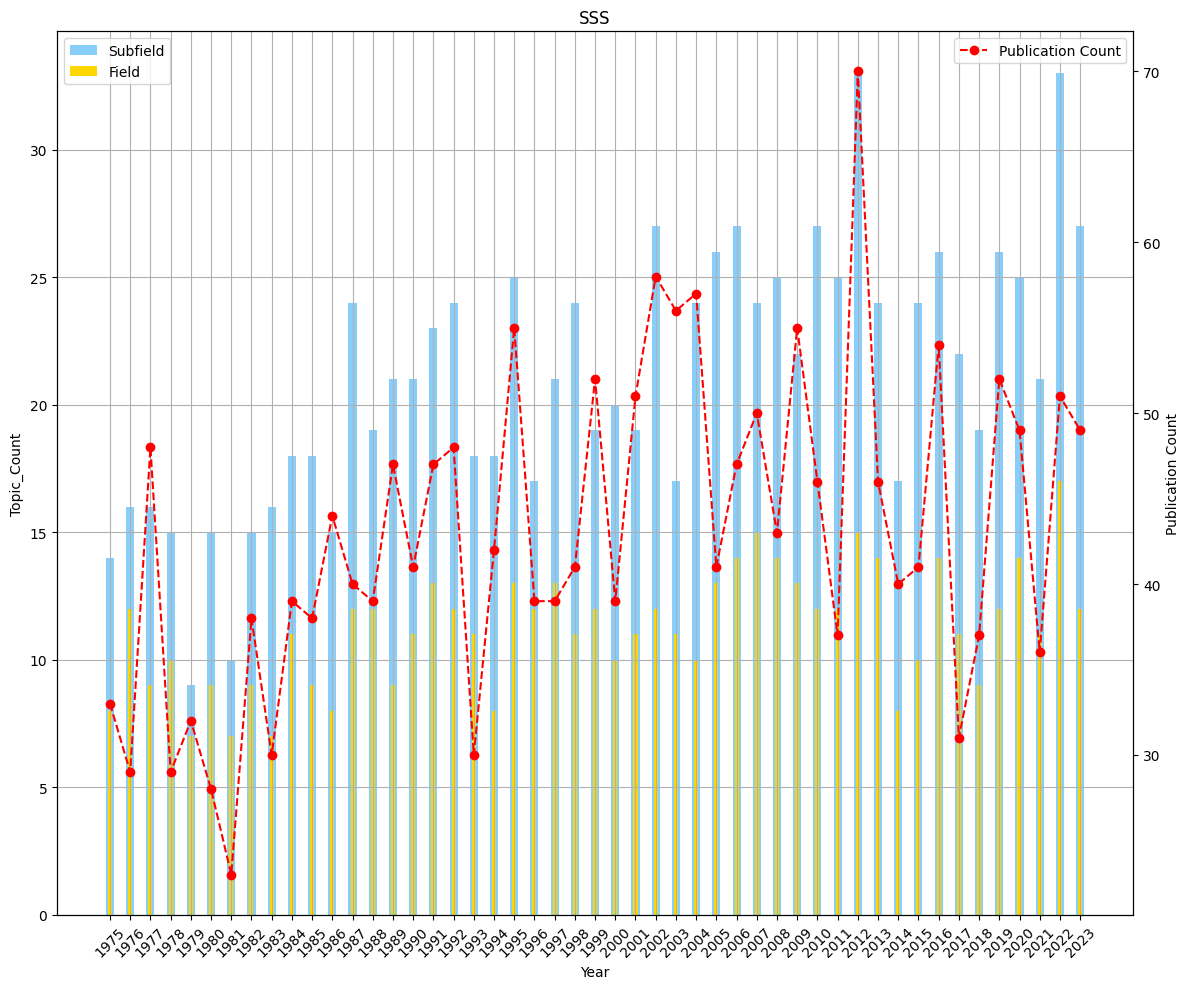

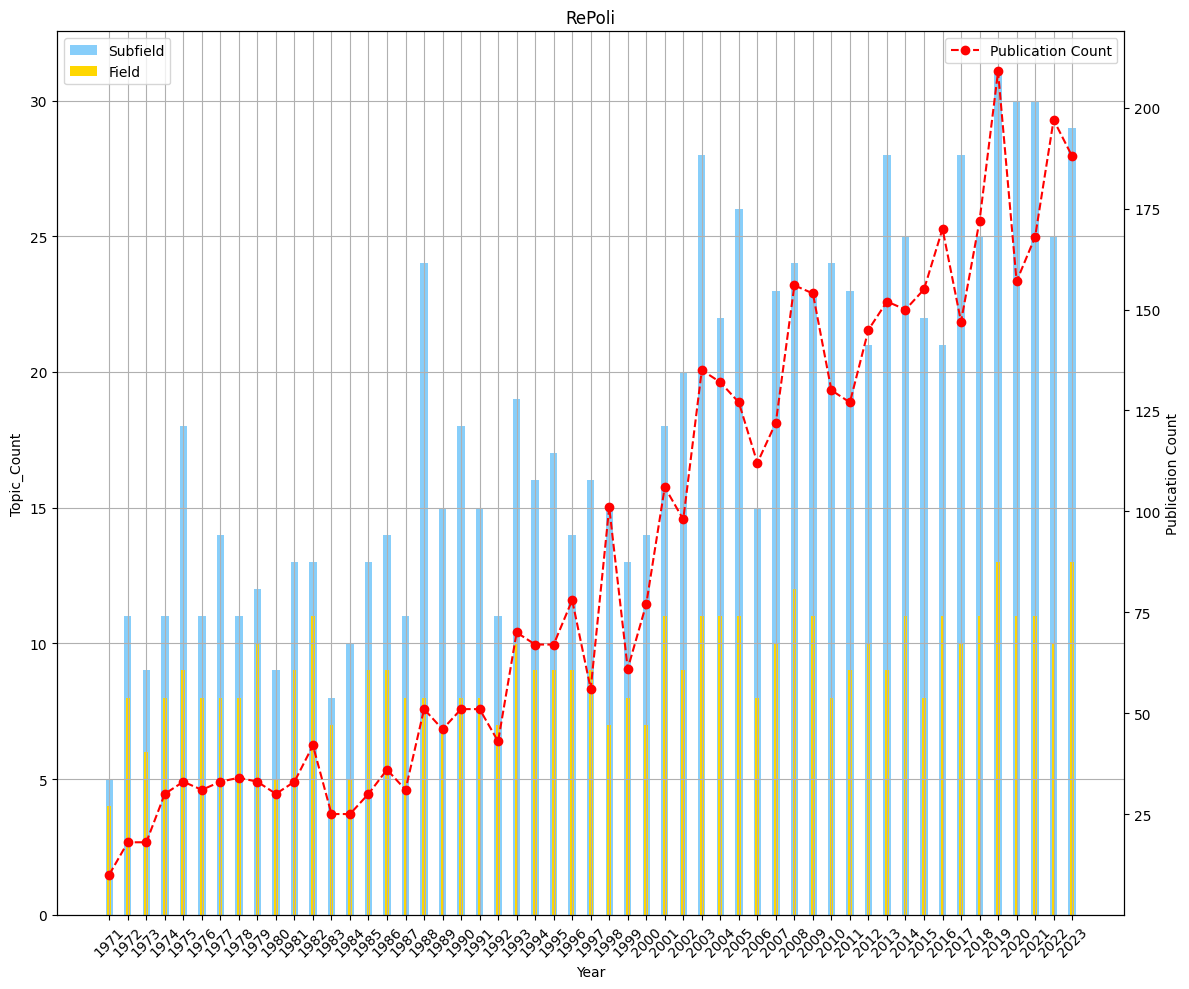

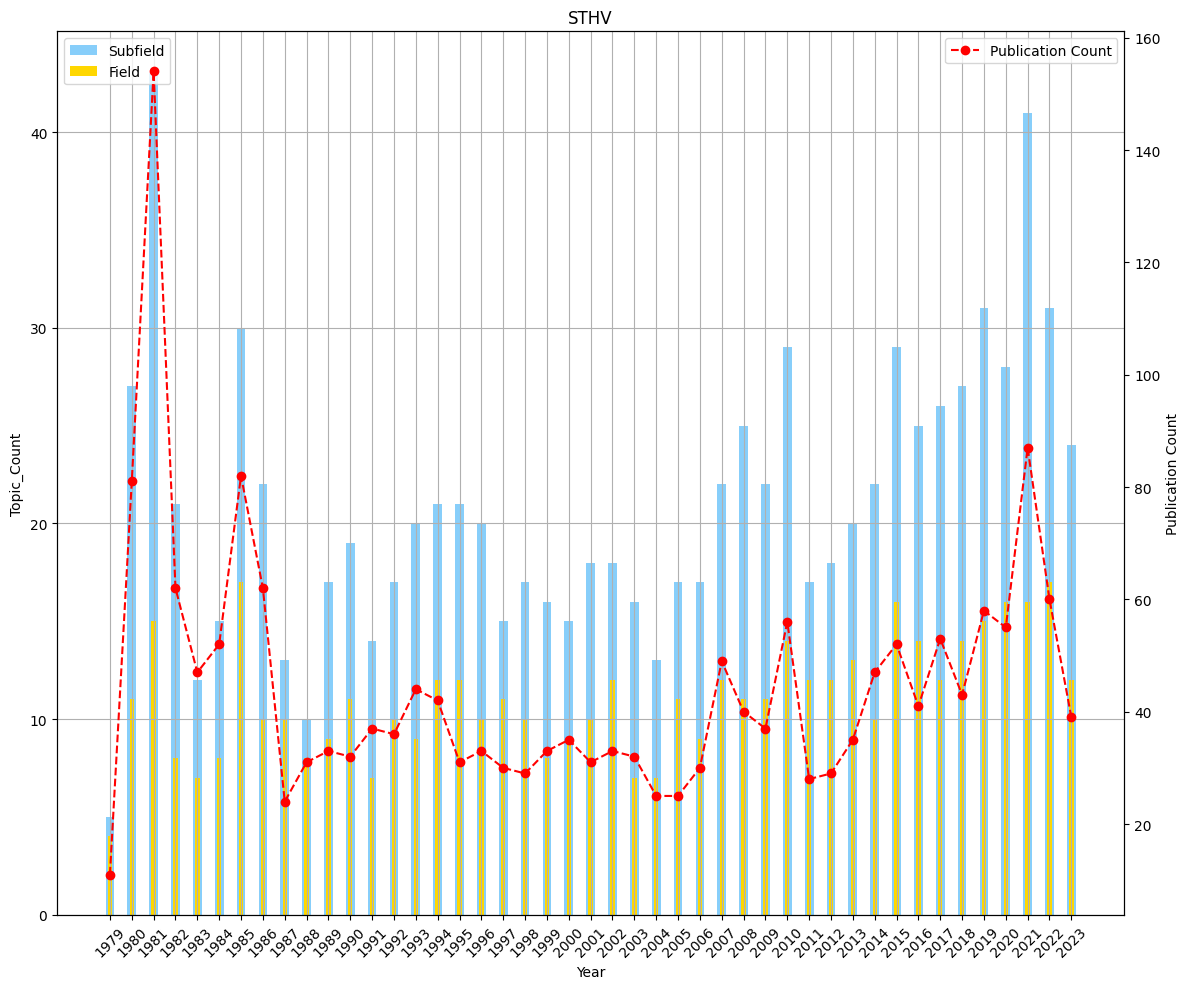

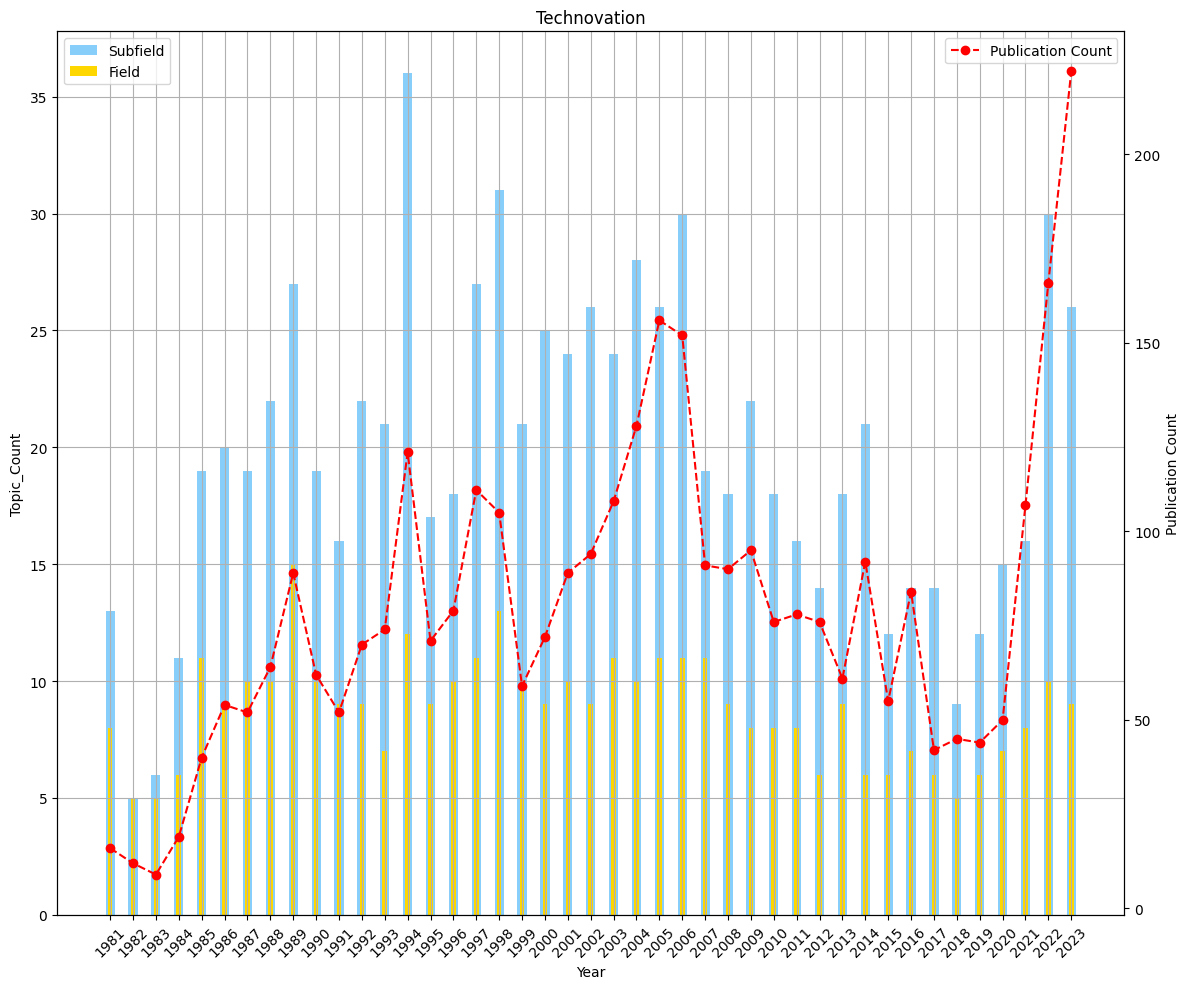

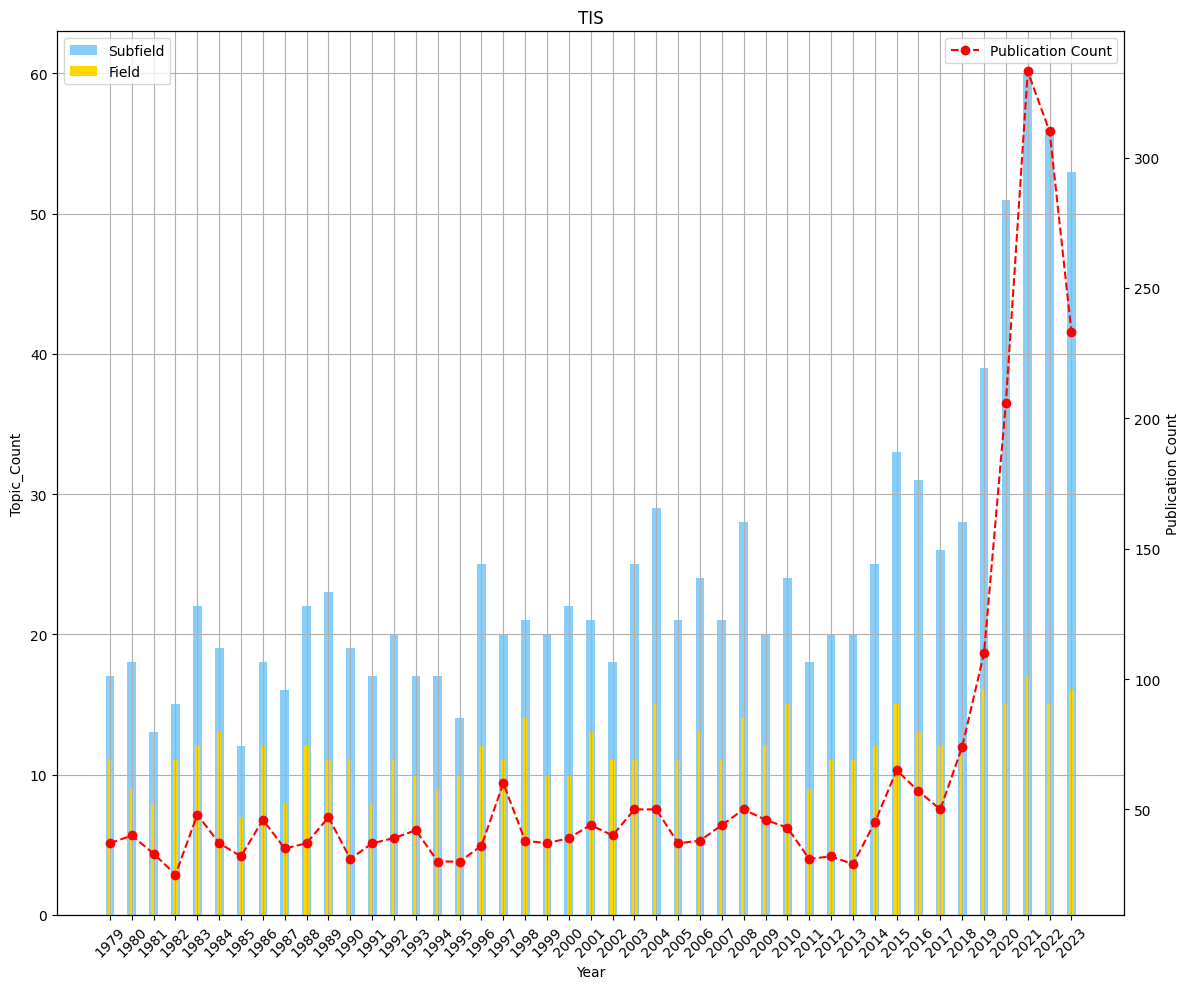

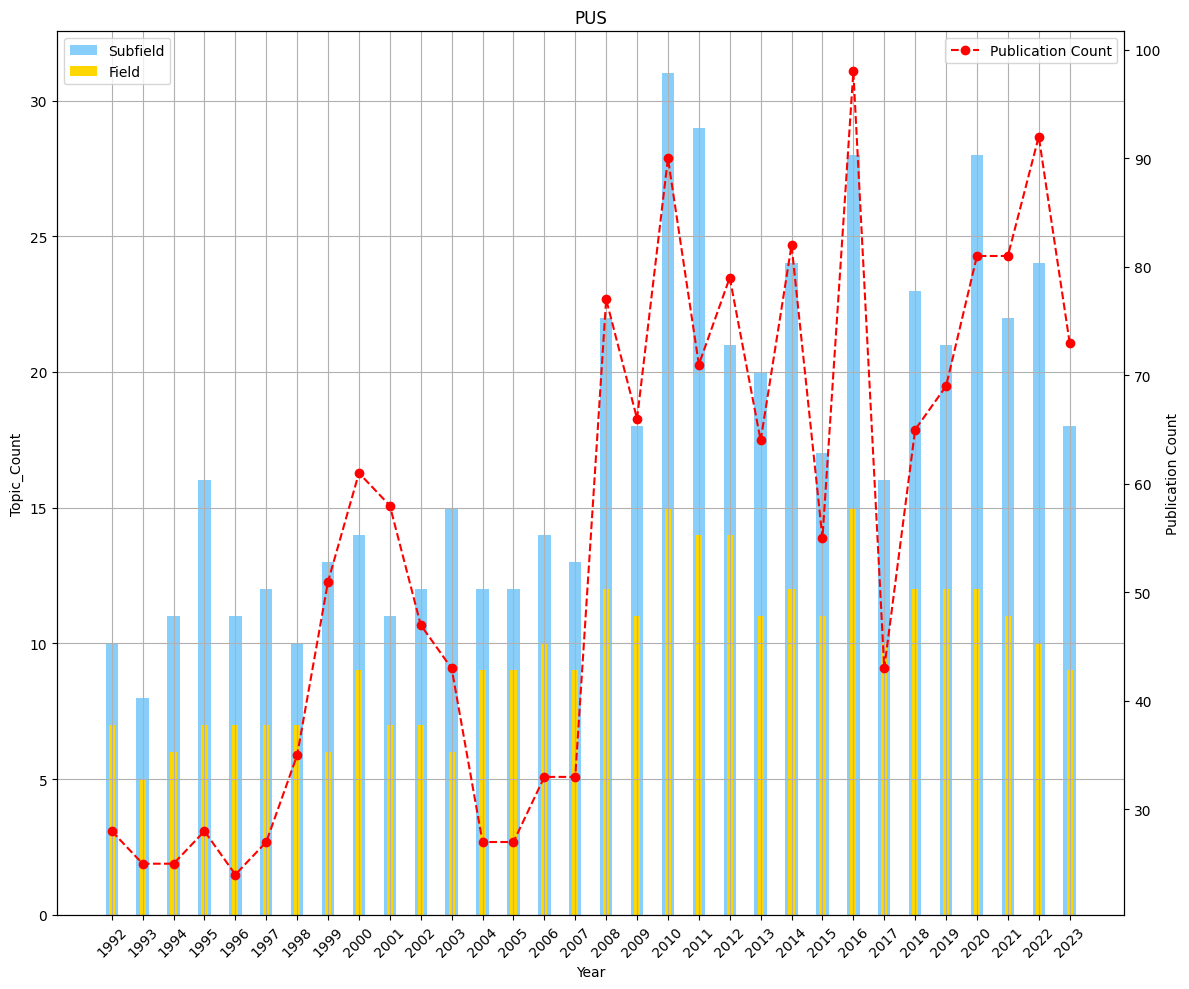

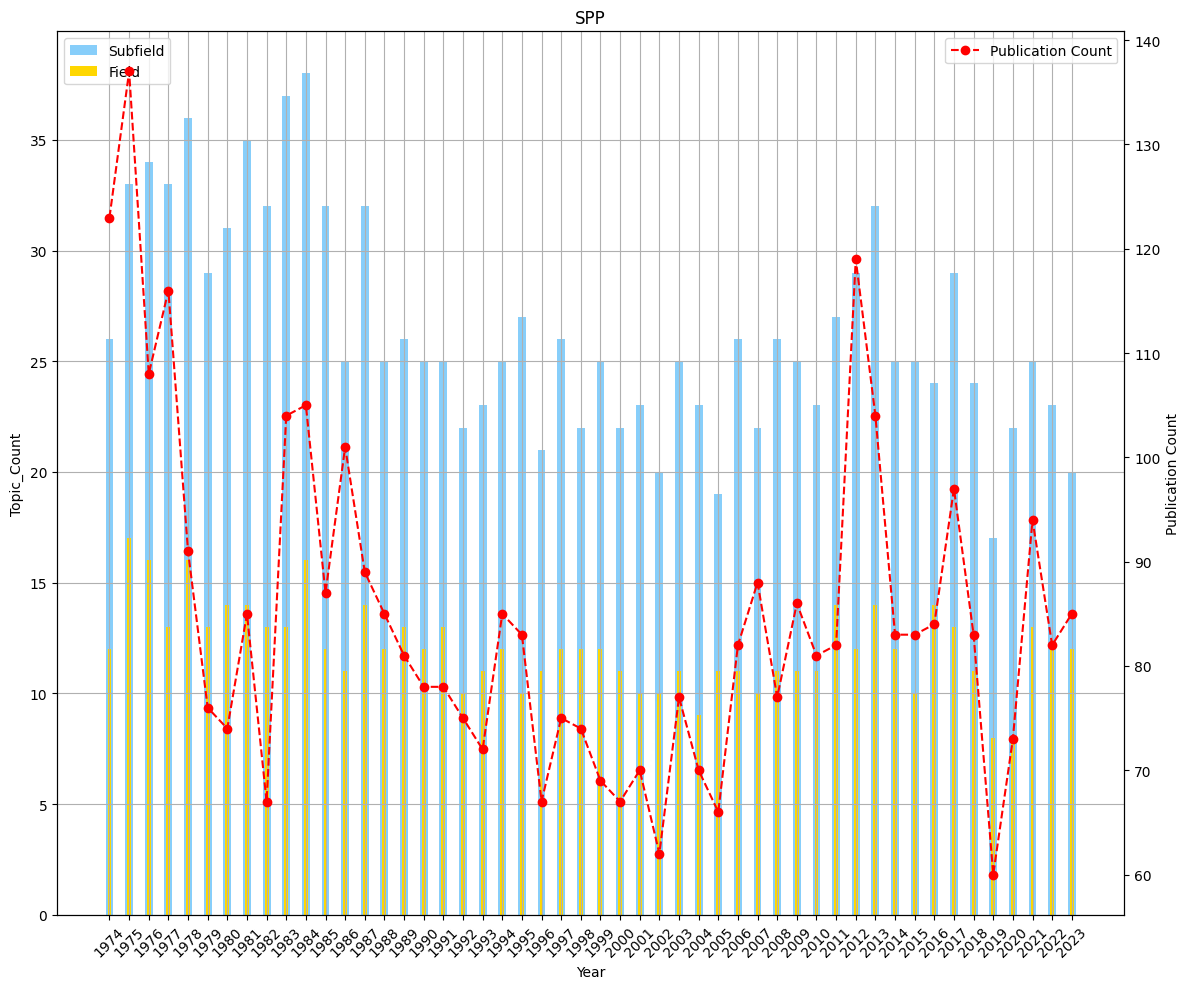

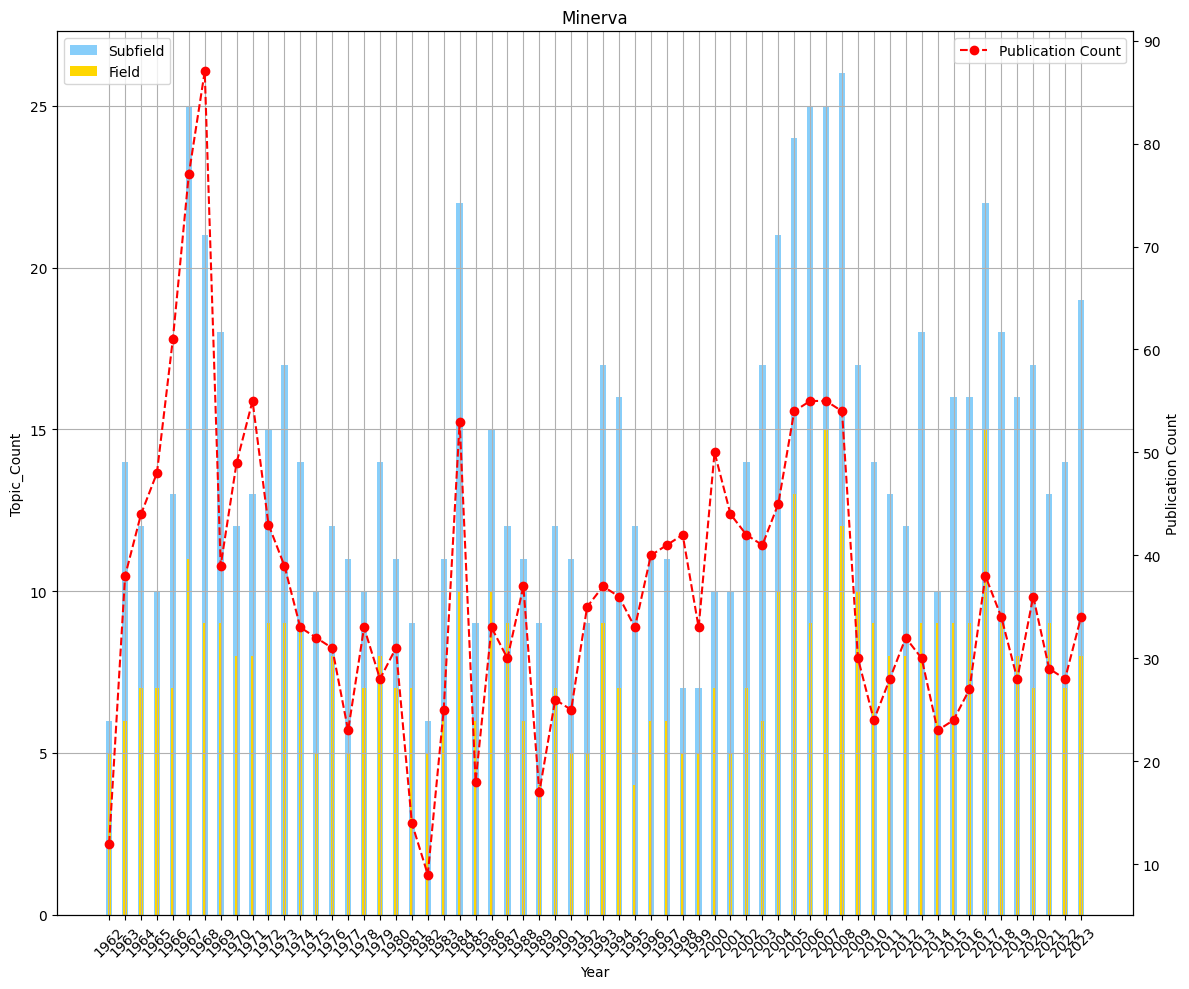

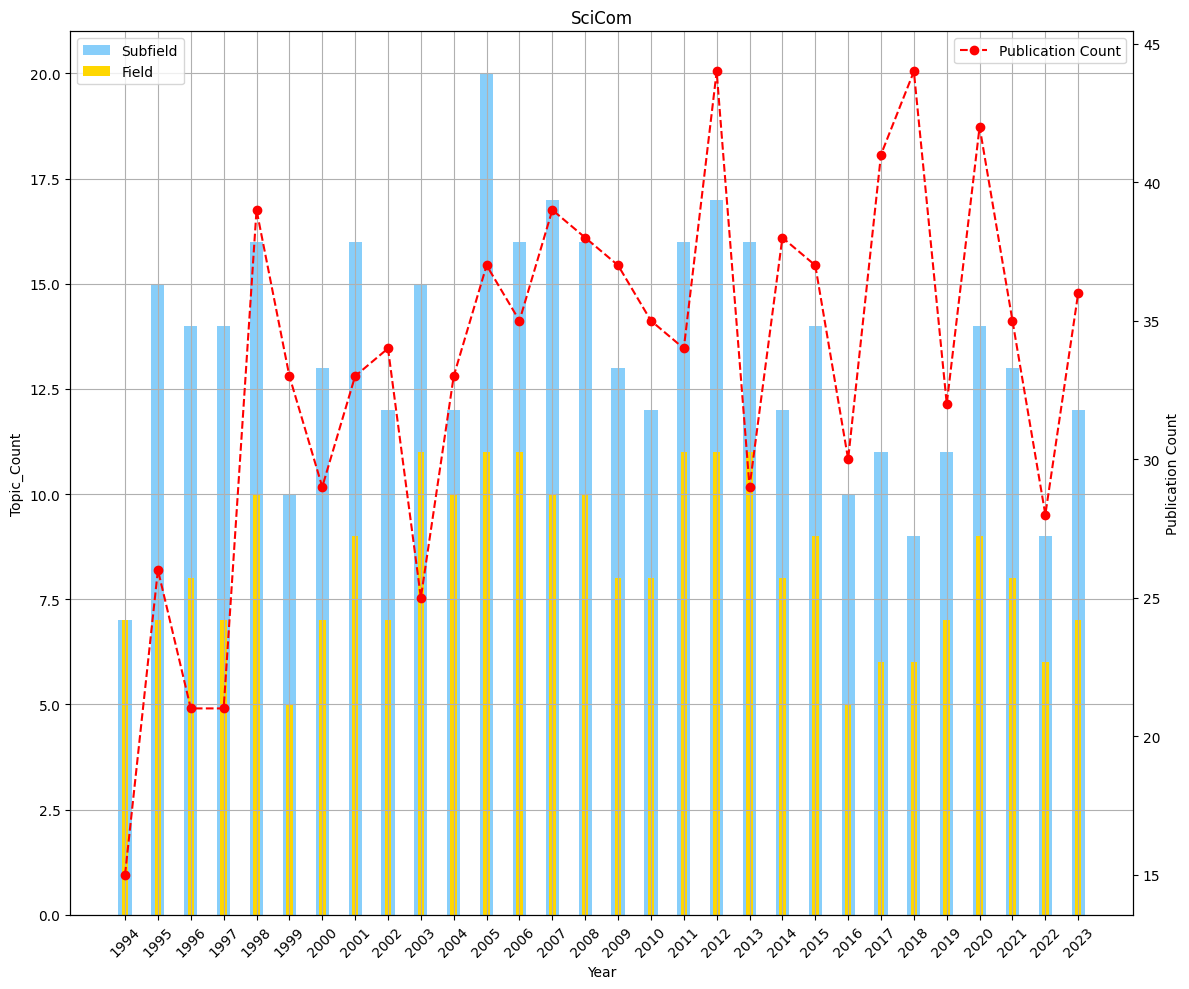

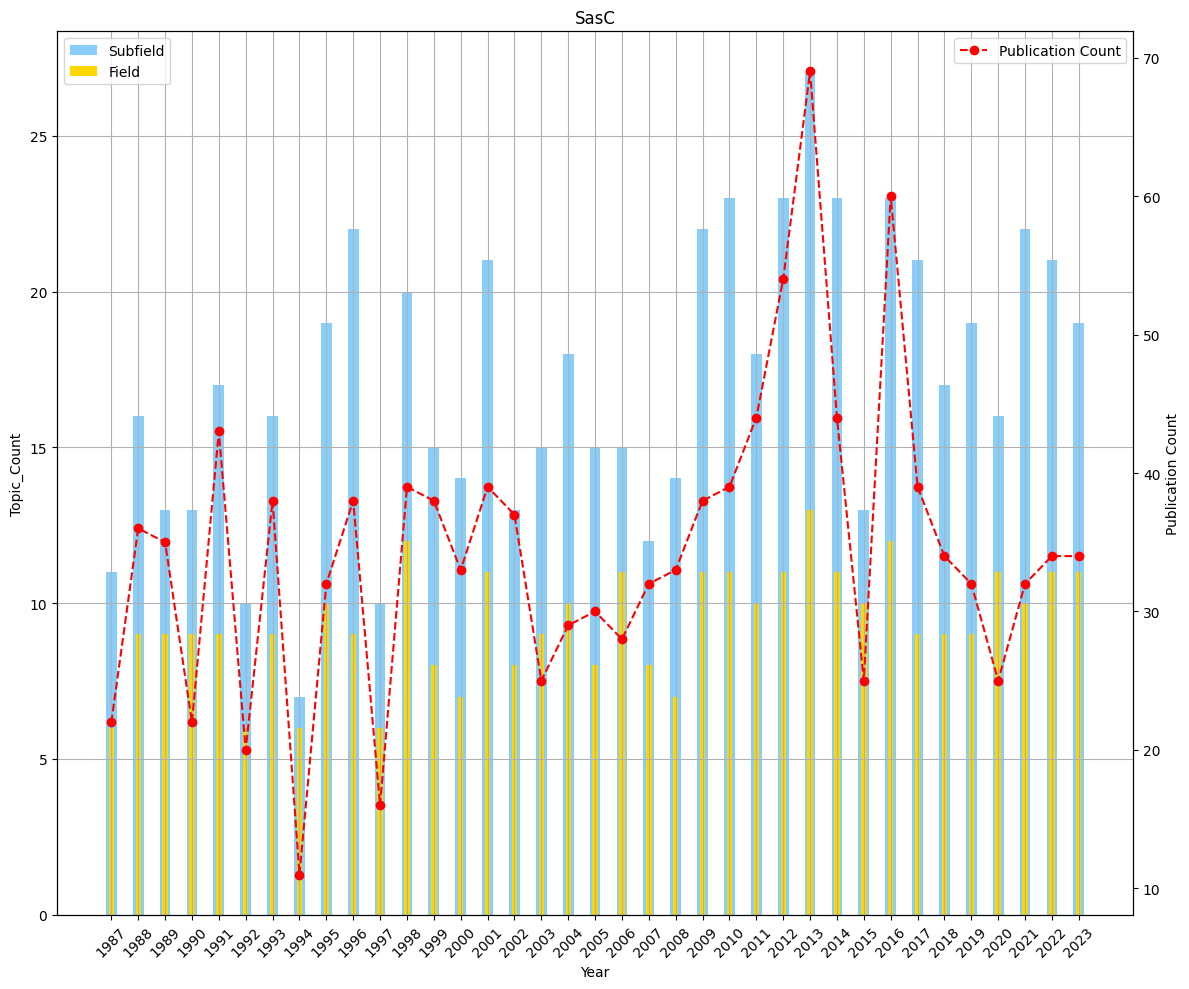

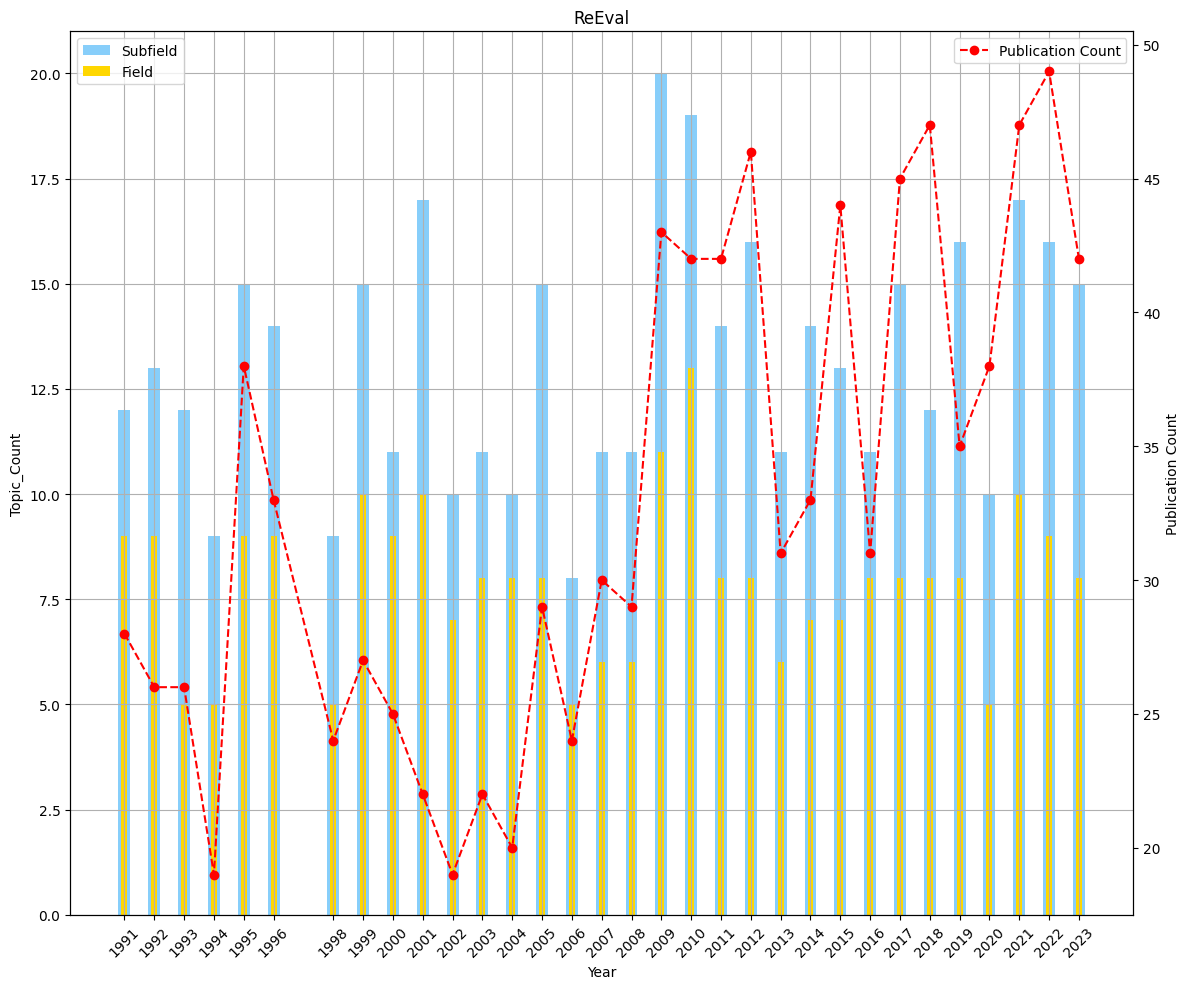

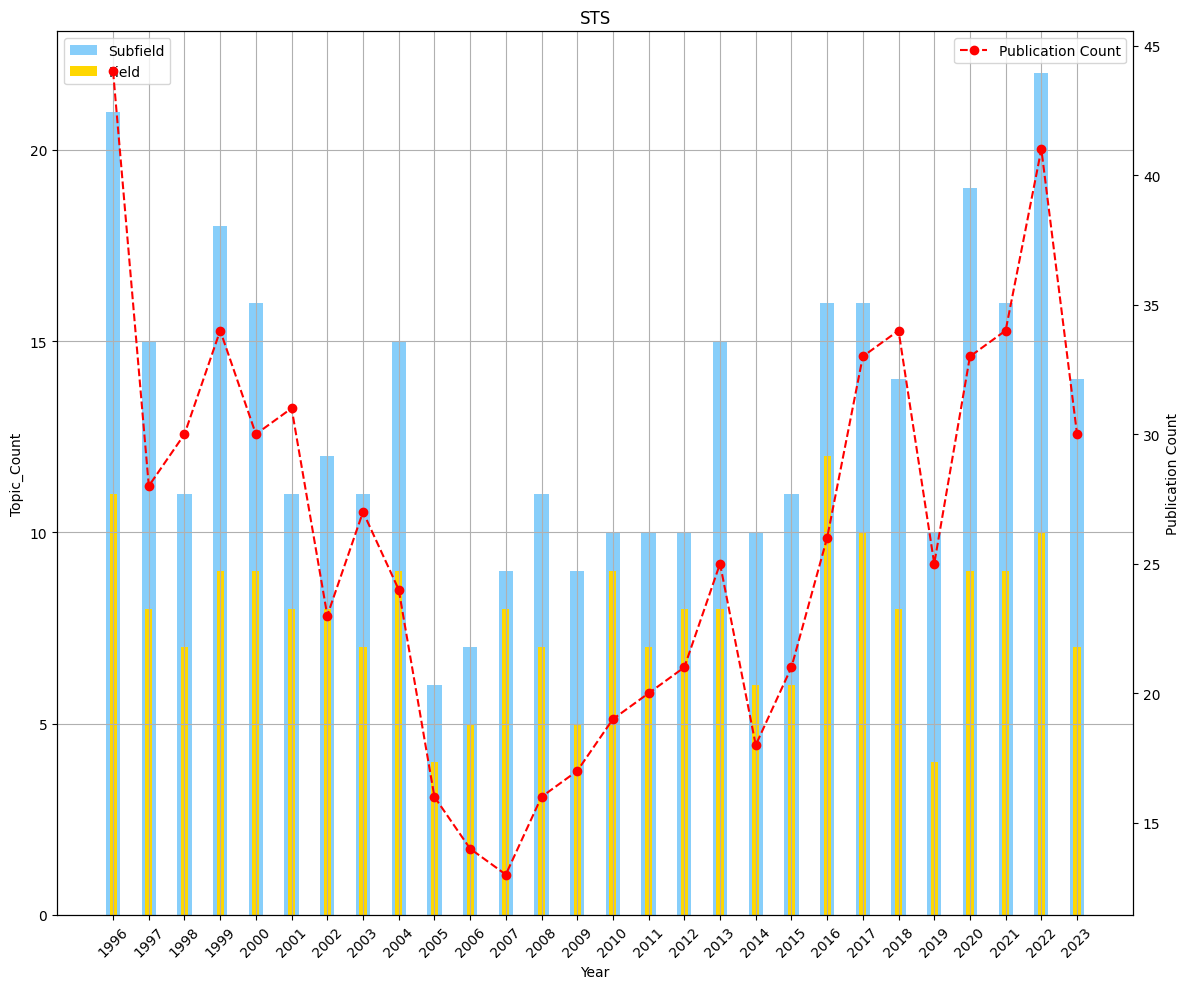

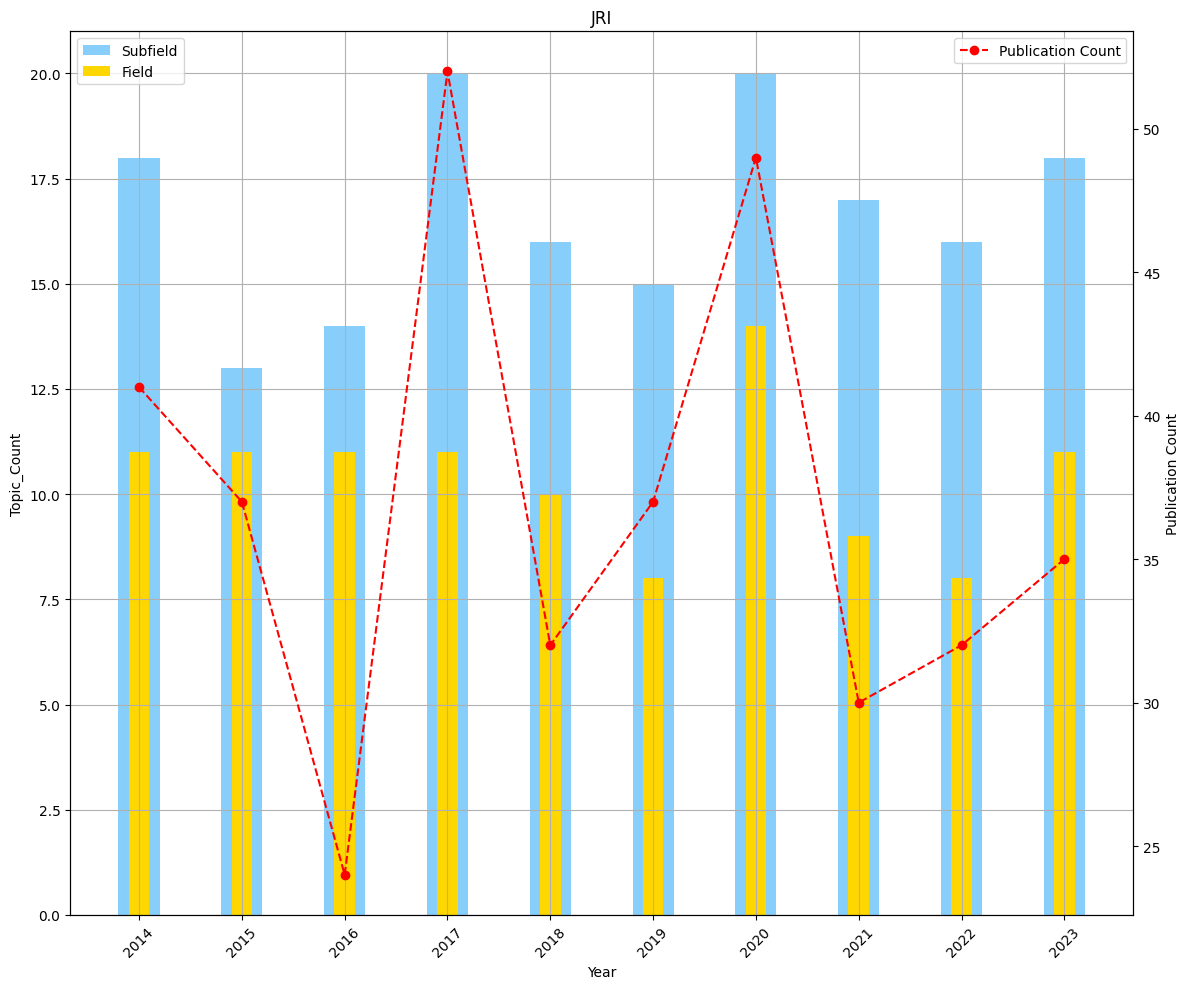

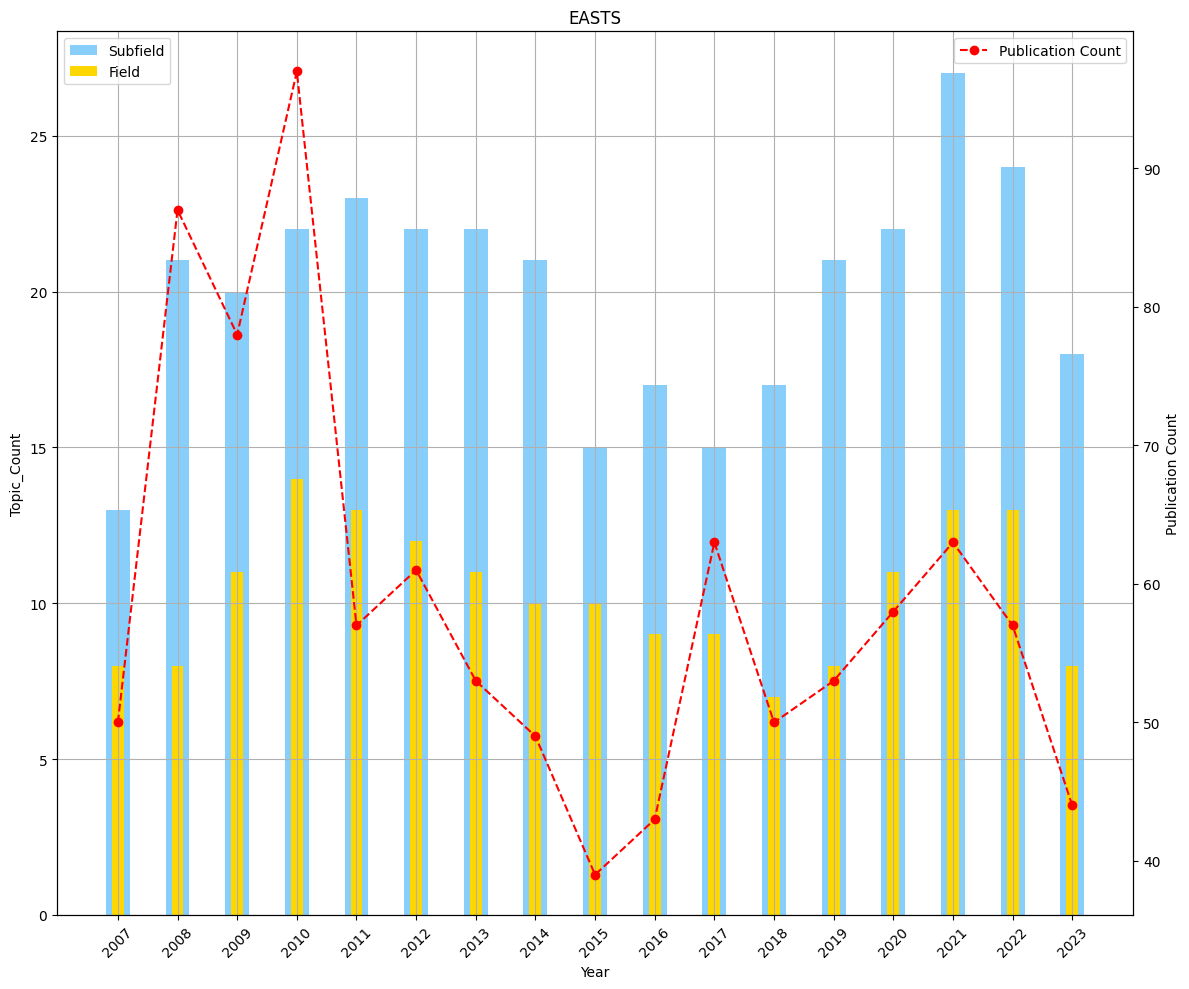

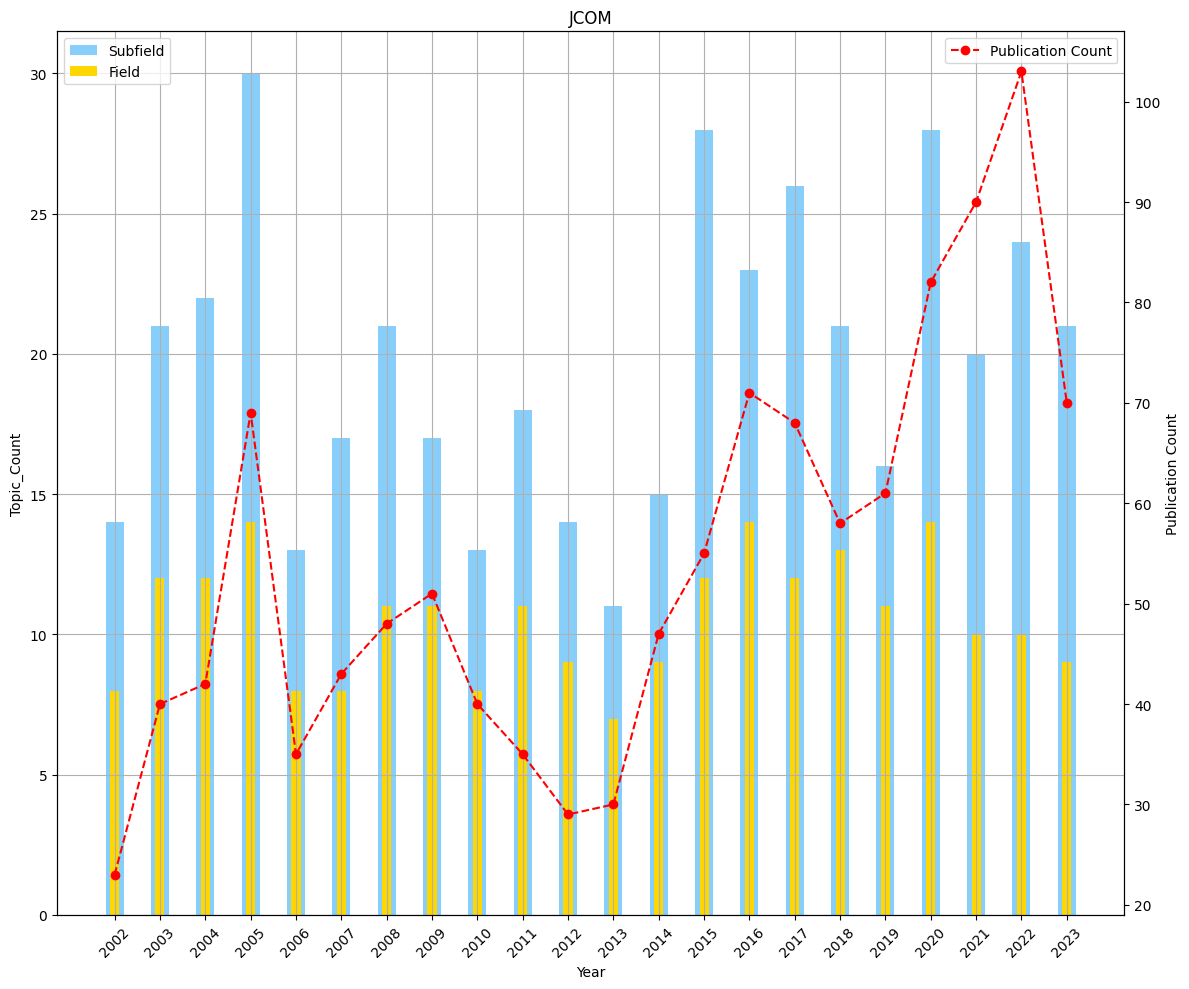

In [144]:
import matplotlib.pyplot as plt

# ジャーナルごとにイテレーション
for journal_name in df['journal_name'].unique():
    # ジャーナルごとにデータを抽出
    journal_data = df[df['journal_name'] == journal_name]

    # 年ごとにサブフィールドの数とフィールドの数を計算
    subfield_counts = journal_data.groupby('publication_year')['subfield'].nunique()
    field_counts = journal_data.groupby('publication_year')['field'].nunique()

    # 年ごとの総ジャーナル数を計算
    total_counts = journal_data.groupby('publication_year').size()

    # グラフのサイズを設定
    fig, ax1 = plt.subplots(figsize=(12, 10))

    # サブフィールド数とフィールド数のプロットを棒グラフで
    ax1.bar(subfield_counts.index, subfield_counts.values , width=0.4, align='center', label='Subfield', color='lightskyblue')
    ax1.bar(field_counts.index, field_counts.values, width=0.2, align='center', label='Field', color='gold')

    # 出版数のプロット（点線）
    ax2 = ax1.twinx()
    ax2.plot(total_counts.index, total_counts.values, marker='o', linestyle='--', label='Publication Count', color='red')

    # グラフのタイトルとラベルを設定
    plt.title(f'{journal_name}')
    ax1.set_xlabel('Year')
    ax1.set_ylabel('Topic_Count')
    ax2.set_ylabel('Publication Count')

    # 凡例を表示
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')

    # x軸を整数値に設定し、45度回転させる
    ax1.set_xticks(subfield_counts.index)
    ax1.set_xticklabels(subfield_counts.index, rotation=45)

    # グリッドを表示
    ax1.grid(True)

    # グラフを表示
    plt.tight_layout()
    plt.show()


# サブジャンルを指標にした類似度


*   サブジャンルの組成をベクトル化
*   リスト項目



In [145]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# サブフィールドの組成をベクトルとして表現する関数
def get_subfield_vector(subfield_counts, subfield_list):
    vector = np.zeros(len(subfield_list))
    for i, subfield in enumerate(subfield_list):
        if subfield in subfield_counts:
            vector[i] = subfield_counts[subfield]
    return vector

# ジャーナル間の類似度を計算する関数
def calculate_similarity(journal_data1, journal_data2, subfield_list):
    # ジャーナルごとのサブフィールドの出現頻度を計算
    subfield_counts1 = journal_data1['subfield'].value_counts().to_dict()
    subfield_counts2 = journal_data2['subfield'].value_counts().to_dict()

    # ジャーナルごとのサブフィールドのベクトルを取得
    vector1 = get_subfield_vector(subfield_counts1, subfield_list)
    vector2 = get_subfield_vector(subfield_counts2, subfield_list)

    # コサイン類似度を計算
    similarity = cosine_similarity([vector1], [vector2])[0][0]
    return similarity


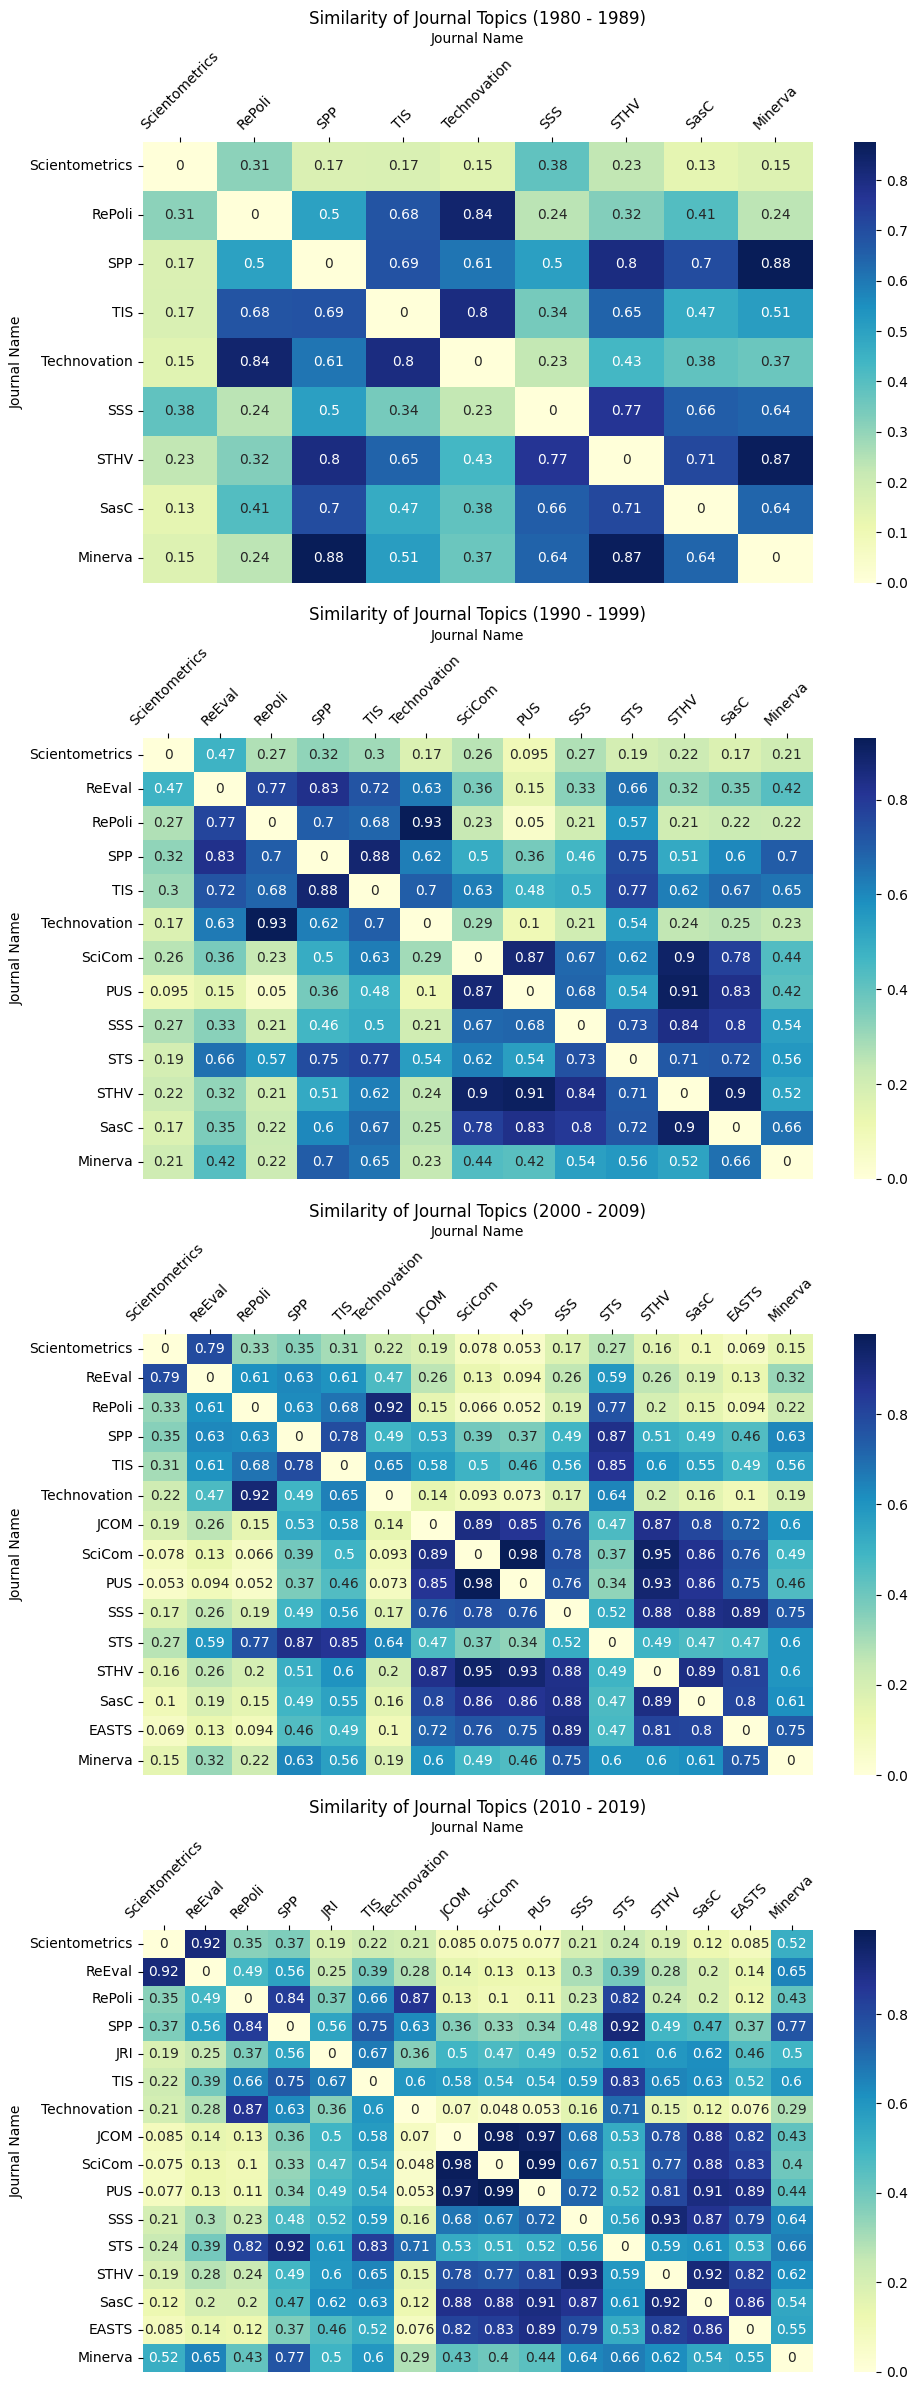

In [150]:
lst =['Scientometrics','ReEval','RePoli','SPP',
 'JRI','TIS','Technovation',
 'JCOM','SciCom','PUS',
 'SSS','STS','STHV','SasC','EASTS','Minerva']

import seaborn as sns

# サブフィールドのリストを取得
subfield_list = df['subfield'].unique()

# 10年ごとのジャーナル間の類似度を計算
years = range(1980, 2020, 10)
fig, axes = plt.subplots(nrows=len(years), ncols=1, figsize=(10, 6 * len(years)))

for i, year in enumerate(years):
    # 10年ごとのジャーナルデータを取得
    journal_data = df[df['publication_year'].between(year, year + 9)]

    # ジャーナル名を抽出
    journal_names = journal_data['journal_name'].unique()
    journal_names = [name for name in lst if name in journal_names]

    # ジャーナル間の類似度行列を作成
    similarity_matrix = np.zeros((len(journal_names), len(journal_names)))
    for j, journal1 in enumerate(journal_names):
        for k, journal2 in enumerate(journal_names):
            if j != k:
                # ジャーナル間の類似度を計算
                similarity = calculate_similarity(journal_data[journal_data['journal_name'] == journal1],
                                                  journal_data[journal_data['journal_name'] == journal2],
                                                  subfield_list)
                similarity_matrix[j, k] = similarity

    # ヒートマップの描画
    sns.heatmap(similarity_matrix, ax=axes[i], cmap="YlGnBu", annot=True, xticklabels=[name for name in journal_names], yticklabels=[name for name in journal_names])
    axes[i].set_title(f'Similarity of Journal Topics ({year} - {year + 9})')
    axes[i].set_xlabel('Journal Name')
    axes[i].set_ylabel('Journal Name')
    axes[i].tick_params(axis='x', labelrotation=45)  # x軸のジャーナル名を45度回転

    # x軸を図の上側に配置
    axes[i].xaxis.tick_top()
    axes[i].xaxis.set_label_position('top')

plt.tight_layout()
plt.show()


# 被引用数の推移

何も言えない

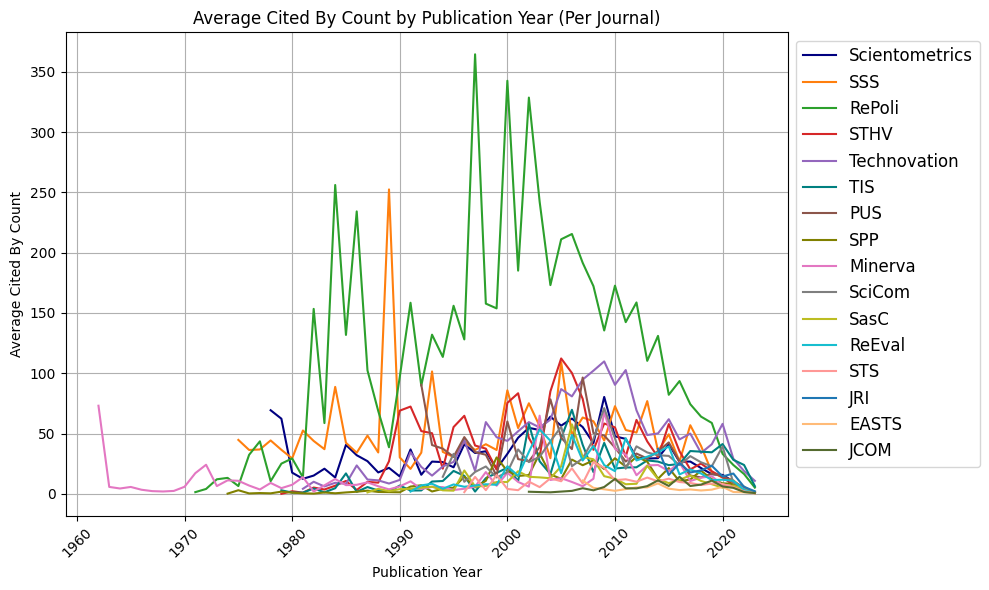

In [149]:

import matplotlib.pyplot as plt

# ジャーナルごとにイテレーション
journals = df['journal_name'].unique()
plt.figure(figsize=(10, 6))

for journal_name in journals:
    # ジャーナルごとにデータを抽出
    journal_data = df[df['journal_name'] == journal_name]

    # 年ごとのcited_by_countの平均を計算
    yearly_mean_cited_by_count = journal_data.groupby('publication_year')['cited_by_count'].mean()

    # プロット
    plt.plot(yearly_mean_cited_by_count.index, yearly_mean_cited_by_count.values, label=journal_name, color=journal_colors.get(journal_name, 'black'))

# グラフのタイトルとラベルを設定
plt.title('Average Cited By Count by Publication Year (Per Journal)')
plt.xlabel('Publication Year')
plt.ylabel('Average Cited By Count')

# 凡例の設定
plt.legend(loc='upper left', fontsize='large', bbox_to_anchor=(1, 1))

# x軸を整数値に設定し、45度回転
plt.xticks(rotation=45)

# グリッドを表示
plt.grid(True)

# グラフを表示
plt.tight_layout()
plt.show()

# 参考文献の数の推移

先行研究通り増加している

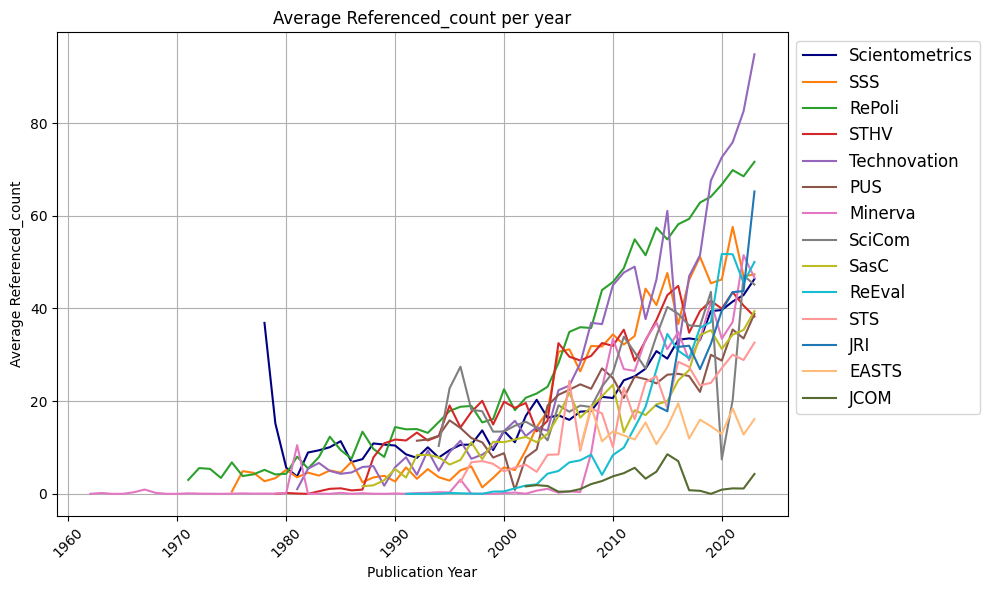

In [131]:
import matplotlib.pyplot as plt

# ジャーナルごとにイテレーション
journals = df['journal_name'].unique()
plt.figure(figsize=(10, 6))

for journal_name in journals:
    # ジャーナルごとにデータを抽出
    journal_data = df[df['journal_name'] == journal_name]


    # 年ごとのcited_by_countの平均を計算
    yearly_mean_referenced_count = journal_data.groupby('publication_year')['referenced_count'].mean()

    # プロット
    plt.plot(yearly_mean_referenced_count.index, yearly_mean_referenced_count.values, label=journal_name, color=journal_colors.get(journal_name, 'black'))

# グラフのタイトルとラベルを設定
plt.title('Average Referenced_count per year')
plt.xlabel('Publication Year')
plt.ylabel('Average Referenced_count')

# 凡例の設定
plt.legend(loc='upper left', fontsize='large', bbox_to_anchor=(1, 1))

# x軸を整数値に設定し、45度回転
plt.xticks(rotation=45)

# グリッドを表示
plt.grid(True)

# グラフを表示
plt.tight_layout()
plt.show()
